# SERGAS data analysis - times scans


author: JAH, JJG

version: 15/06/20


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
import matplotlib.dates as mdates
print("Last updated on ", time.asctime())

Last updated on  Fri Jul 10 00:06:00 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

from copy import copy

from scipy import stats

import c19.useir      as us
import c19.useir_plot as usp
#import c19.useir_ana as usa

In [4]:
import ipywidgets as widgets
from ipywidgets import IntProgress
from IPython.display import display

In [5]:
from c19.data_functions_HG import hg_get_data_ingresos, hg_get_data_pacientes, hg_get_data_age
from c19.HG_analysis import plot_hgi, plot_nh_nu, recovery_time, exitus_time, exitus_group, exitus, hosp_uci, select_age_by_CA_and_sex
from c19.HG_analysis import hist_XY_series, plot_XY_series, plot_pop_age
from c19.HG_analysis import formatter

In [6]:
datapath="/Users/hernando/investigacion/bio/c19/data/HospitalesGalicia"
file = "IngresosCovid.csv"
filep = "PacientesCOVID.csv"
ff =f'{datapath}/{file}'
fp =f'{datapath}/{filep}'
dfi = pd.read_csv(ff, sep='|')

## HGalicia

In [7]:
def get_cases(df, index = 'ingreso'):
    nps = df.groupby([index]).pacienteID.count()
    sel = nps.index >= np.datetime64('2020-02-15')
    dates, cases = nps.index[sel].values, nps.values[sel]
    return dates, cases

def get_deaths(dfp, code = 'EXITUS'):
    sel = (dfp.code == 'EXITUS') & (dfp.alta.values >= np.datetime64('2020-02-01'))
    dfe = dfp[sel] 
    nps = dfe.groupby(['alta']).pacienteID.count()
    dates, cases = nps.index.values, nps.values
    return dates, cases

def plot_cases(dates, cases, title = ''):
    plt.figure(figsize = (8, 6))
    plt.errorbar(dates, cases, yerr = np.maximum(np.sqrt(cases), 2.4), 
                 ls = '', marker = 'o', ms = 4)
    formatter(plt.gca());

In [8]:
hgi = hg_get_data_ingresos(ff)
dates, cases = get_cases(hgi)
sel = dates >= np.datetime64('2020-03-01') 
dates, cases = dates[sel], cases[sel]

### Fit cases - best fit

We fit the cases vs time in Galicia to the uSEIRq (quenched model)

Select cases starting first of March. 

Initial parameters are based on previous fits. We fit the number of detected cases.

In [9]:
def get_fun(ffit):
    fun   = us.chi2
    if ffit == 'mll' : fun = us.mll
    if ffit == 'emll': fun = us.emll
    return fun

def plt_kpars(dates, cases, kpars, fmodel, ffit = 'chi2'):
    pars  = us.kpars_to_pars(kpars, fmodel)
    usp.plt_data_model(dates, cases, pars, fmodel)
    fun = get_fun(ffit)
    ts  = us.to_ts(dates)
    fval  = fun(ts, cases, pars, fmodel)
    print('best pars ', kpars, ', chi2 ', fval)
    
def plt_kpars_fit(dates, cases, kpars, pmask, fmodel, ffit = 'chi2'):
    kpars, fval, ffun = us.dms_fit(dates, cases, fmodel, kpars, pmask, ffit = 'chi2')
    print('best pars ', kpars, ', chi2, chi2/ndf ', fval, fval/(len(dates)- len(pmask)))
    usp.plt_data_model(dates, cases, kpars, fmodel)

In [10]:
# initial parameters based in previous fits
kpars0 = {'t0': 22.57, 'beta': 1.48, 'gamma': 0.22, 
          'tr': 2.7, 'ti': 4.7, 'n': 2701743.0, 'phim': 0.068, 
          's1': 0.0071, 'chi2': 141.48}

kpars0 =  {'t0': 22.79, 'beta': 1.48, 'gamma': 0.226, 'ti': 4.75, 'tr': 2.7, 
           'n': 2701743.0, 'phim': 0.0661, 's1': 0.0072}

best pars  {'t0': 22.79, 'beta': 1.48, 'gamma': 0.226, 'ti': 4.75, 'tr': 2.7, 'n': 2701743.0, 'phim': 0.0661, 's1': 0.0072} , chi2  136.65732953786238


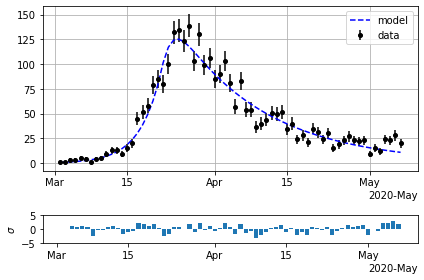

In [11]:
fmodel = us.dms_t0useirq_tr
ffit   = 'chi2'
plt_kpars(dates, cases, kpars0, fmodel = fmodel, ffit = ffit)

best pars  {'t0': 22.698893846118345, 'beta': 1.48114595399913, 'gamma': 0.22313416409284798, 'ti': 4.75, 'tr': 2.7, 'n': 2701743.0, 'phim': 0.0661, 's1': 0.0072} , chi2, chi2/ndf  135.94408977430226 2.1241264027234728


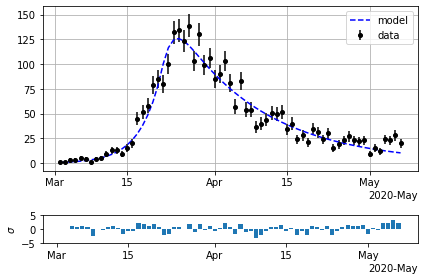

In [12]:
pmask  = ('t0', 'beta', 'gamma')
plt_kpars_fit(dates, cases, kpars0, pmask, fmodel = fmodel, ffit = ffit);

Considering that the confinement started the 15th of March. The peak of the pandemie accurred:

In [13]:
tdelay = 2
date0 = dates[np.argmax(cases) - tdelay] - np.datetime64('2020-03-15')
print('peak after quarentine : ', np.timedelta64(date0, 'D'))

peak after quarentine :  10 days


## scan in Tr/Ti - other parameters fixed to best values

Fixing the parameters we scan along Tr

In [14]:
tr, ti = 2.7, 4.75
def times_scan(dates, cases, kpars0, trs = (tr,), tis = (ti,), fmodel = us.dms_t0useirq_tr, ffit = 'chi2'):
    ts = us.to_ts(dates)
    dpars = []
    for ti in tis:
        for tr in trs:
            kpars = copy(kpars0); kpars['tr'] = tr; kpars['ti'] = ti
            pars  = us.kpars_to_pars(kpars, fmodel)
            fun = get_fun(ffit)
            fval  = fun(ts, cases, pars, fmodel)
            #kpars, fval, ffun = us.dms_fit(dates, cases, fmodel, kpars, pmasks, ffit = ffit)
            kpars['fval'] = fval
            dpars.append(kpars)  
    return pd.DataFrame(dpars)

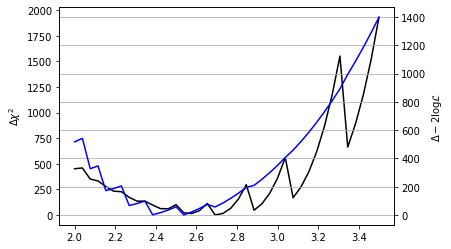

In [15]:
tr0, tr1 = 2.0, 3.5
trs = np.linspace(tr0, tr1, 40)

colors = ['black', 'blue']
labels = [r'$\Delta \chi^2$', r'$\Delta - 2 \log \mathcal{L}$']
for i, ffit in enumerate(['chi2', 'mll']):
    dpars = times_scan(dates, cases, kpars0, trs = trs, ffit = ffit)
    ax = plt.gca() if ffit == 'chi2' else plt.twinx()
    ax.plot(dpars.tr, dpars.fval - np.min(dpars.fval), color = colors[i], label = labels[i])
    ax.set_ylabel(labels[i]); # ax.legend();
plt.xlabel(r'$T_r$ (days) ', fontsize = 12); plt.grid();

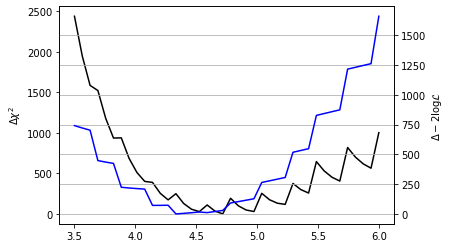

In [16]:
ti0, ti1 = 3.5, 6.0
tis = np.linspace(ti0, ti1, 40)

colors = ['black', 'blue', 'red']
labels = [r'$\Delta \chi^2$', r'$\Delta - 2 \log \mathcal{L}$']
for i, ffit in enumerate(['chi2', 'mll']):
    dpars = times_scan(dates, cases, kpars0, tis = tis, ffit = ffit)
    ax = plt.gca() if ffit == 'chi2' else plt.twinx()
    ax.plot(dpars.ti, dpars.fval - np.min(dpars.fval), color = colors[i], label = ffit)
    ax.set_ylabel(labels[i]); # ax.legend();
plt.xlabel(r'$T_i$ (days)', fontsize = 12); plt.grid();

*There are some structures in the $\chi^2$ and $- 2 \log \mathcal{L}$ scan, why?*

*Could be related with the dms calculation in time of 1 day, do we need a smaller step?*

### scan in Tr/Ti - Other parameters are free in the fit

We fix $s1, \, \phi_m$, and let floating $t_0, \beta, \gamma$. We estimate the best parameters via the fit, fixing some other parameters.

In [17]:
tr, ti = 2.7, 4.75
pmask0 = ('t0', 'beta', 'gamma')
def times_fit_scan(dates, cases, kpars0, pmask0, trs = (tr,), tis = (ti,), 
                   fmodel = us.dms_t0useirq_tr, ffit = 'chi2'):
    ts = us.to_ts(dates)
    dpars = []
    for ti in tis:
        for tr in trs:
            kpars = copy(kpars0); kpars['tr'] = tr; kpars['ti'] = ti
            pars  = us.kpars_to_pars(kpars, fmodel)
            fun = get_fun(ffit)
            fval  = fun(ts, cases, pars, fmodel)
            kpars, fval, ffun = us.dms_fit(dates, cases, fmodel, kpars, pmask0, ffit = ffit)
            kpars['fval'] = fval
            dpars.append(kpars)  
    return pd.DataFrame(dpars)

In [18]:
def plt_tscan(df, xx, xlabel):
    plt.figure(figsize = (2* 5, 3 * 4))
    plt.subplot(3, 2, 1)
    plt.plot(xx, df.fval - np.min(df.fval)); 
    plt.grid(); plt.ylabel(r'$\Delta \chi^2$'); plt.xlabel(xlabel)
    plt.subplot(3, 2, 2)
    plt.plot(xx, df.t0); plt.grid(); plt.ylabel(r'$T_0$'); plt.xlabel(xlabel)
    plt.subplot(3, 2, 3)
    plt.plot(xx, df.beta);  plt.grid(); plt.ylabel(r'$\beta$'); plt.xlabel(xlabel)
    plt.subplot(3, 2, 4)
    plt.plot(xx, df.gamma); plt.grid(); plt.ylabel(r'$\gamma$'); plt.xlabel(xlabel)
    plt.subplot(3, 2, 5)
    plt.plot(xx, df.phim); plt.grid(); plt.ylabel(r'$\phi_m$'); plt.xlabel(xlabel)
    plt.subplot(3, 2, 6)
    plt.plot(xx, df.s1); plt.grid(); plt.ylabel(r'$s1$'); plt.xlabel(xlabel)
    plt.tight_layout()

,beta,fval,gamma,n,phim,s1,t0,ti,tr
0,1.663505,136.462513,0.297166,2701743.0,0.0661,0.0072,23.247371,4.75,2.0
1,1.565500,136.004198,0.250688,2701743.0,0.0661,0.0072,22.548622,4.75,2.4
2,1.547727,137.181851,0.218022,2701743.0,0.0661,0.0072,21.179794,4.75,2.8
3,1.319938,140.355518,0.193481,2701743.0,0.0661,0.0072,24.134791,4.75,3.2
4,1.554843,138.954141,0.167128,2701743.0,0.0661,0.0072,18.796069,4.75,3.6
5,1.700794,143.262445,0.150537,2701743.0,0.0661,0.0072,16.459445,4.75,4.0


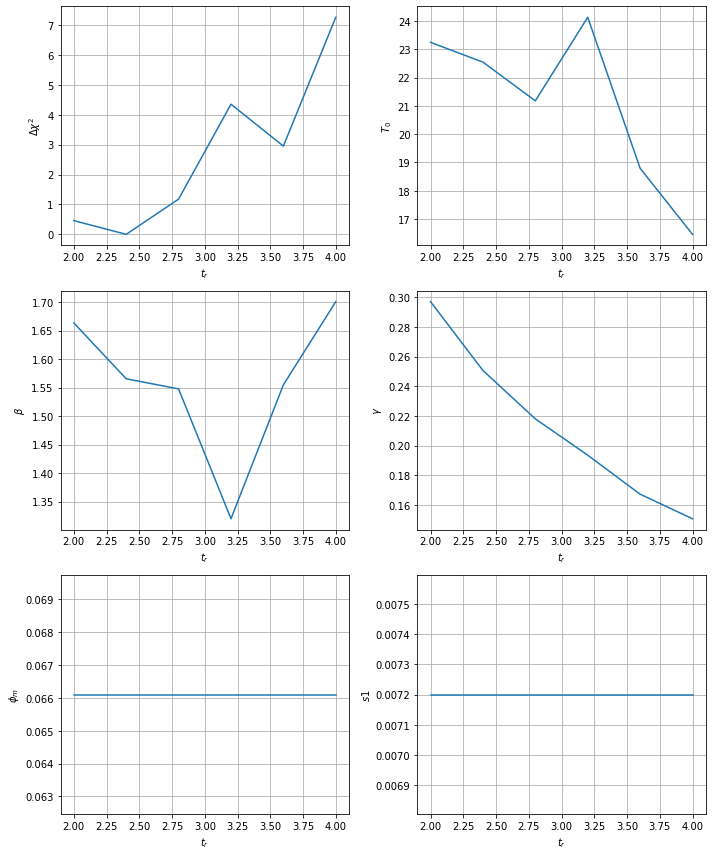

In [ ]:
trs = np.linspace(2., 4., 6)
dpars = times_fit_scan(dates, cases, kpars0, pmask0, trs = trs)
plt_tscan(dpars, dpars.tr, r'$t_r$')
dpars

*The change in $t_r$ is reabsorbed mostly in $\gamma$ and $T_0$. That implies that we are moving along a minimum valley.* 

,beta,fval,gamma,n,phim,s1,t0,ti,tr
0,1.328291,136.351153,0.232688,2701743.0,0.0661,0.0072,22.429948,4.00,2.7
1,1.418534,136.442717,0.230278,2701743.0,0.0661,0.0072,21.635143,4.25,2.7
2,1.471342,136.461561,0.227344,2701743.0,0.0661,0.0072,21.730232,4.50,2.7
3,1.481146,135.944090,0.223134,2701743.0,0.0661,0.0072,22.698894,4.75,2.7
4,1.490219,135.985794,0.218899,2701743.0,0.0661,0.0072,23.663046,5.00,2.7
5,1.542459,136.121148,0.215026,2701743.0,0.0661,0.0072,23.730784,5.25,2.7
6,1.549436,136.699523,0.210763,2701743.0,0.0661,0.0072,24.689730,5.50,2.7
7,1.649142,136.511031,0.207314,2701743.0,0.0661,0.0072,23.863223,5.75,2.7


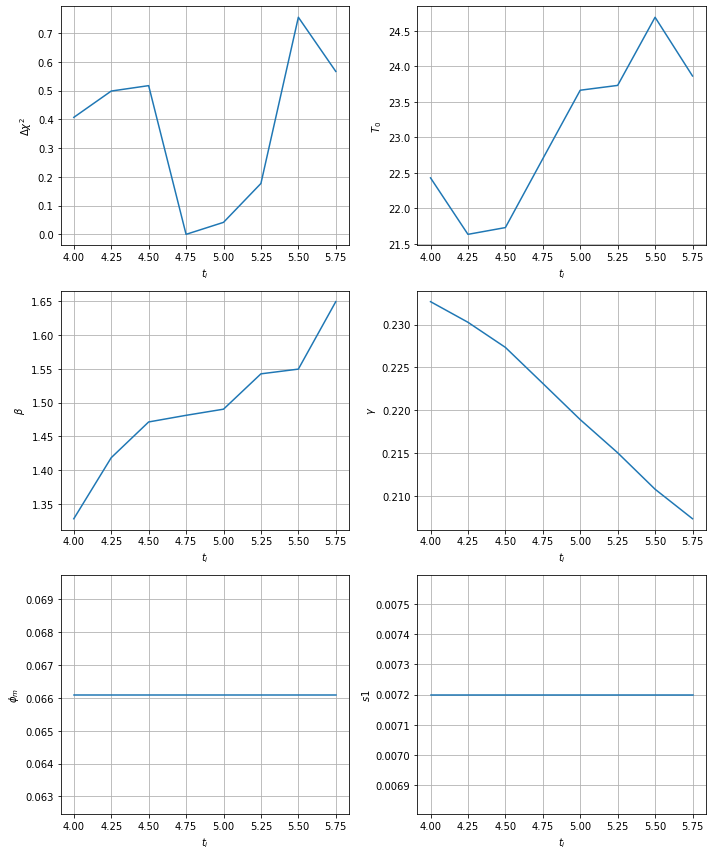

In [ ]:
tis = np.linspace(4., 5.75, 8)
dpars = times_fit_scan(dates, cases, kpars0, pmask0, tis = tis)
plt_tscan(dpars, dpars.ti, r'$t_i$')
dpars

In scan along $t_i$ is somehow more clear, still some coverage of the change in $t_i$ by $\beta, \gamma$. 

Maybe the selection of the points along $t_i$ could result in the 'parabola' shape of the $\chi^2$

### scan in Ti/Tr - saved values of previous NB

In a previos NB (slightly different fit code) we have obtained via interation of fits, the following best points during the scan along $t_r$ and $t_i$:

,t0,beta,gamma,tr,ti,n,phim,s1,fval
0,16.677387,1.839708,0.300818,2.000000,5.0,2701743.0,0.046409,0.008086,146.013467
1,15.620843,1.713789,0.257476,2.333333,5.0,2701743.0,0.059081,0.007946,142.830439
2,17.534211,1.499701,0.225692,2.666667,5.0,2701743.0,0.064463,0.007325,141.446923
3,19.251459,1.334008,0.200031,3.000000,5.0,2701743.0,0.067168,0.007022,143.434733
4,21.600752,1.201931,0.178988,3.333333,5.0,2701743.0,0.067802,0.007531,148.122706
5,23.417914,1.094039,0.161404,3.666667,5.0,2701743.0,0.066971,0.007377,155.054552
6,26.581777,1.003732,0.147043,4.000000,5.0,2701743.0,0.053502,0.008786,164.257231


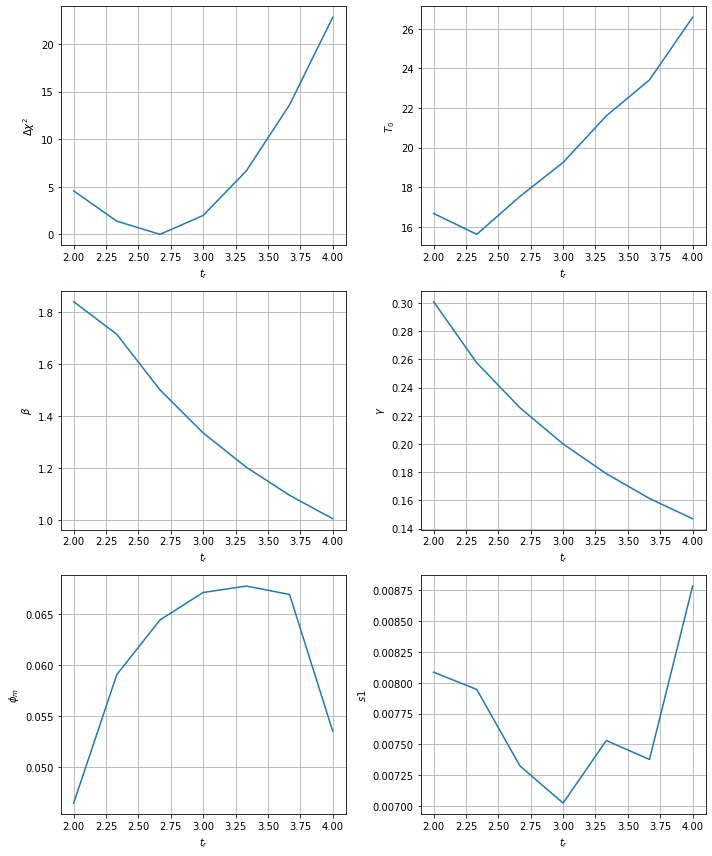

In [ ]:
path  = '/Users/hernando/investigacion/bio/C19/data/'
ifile = 'hgalicia_tr_scan_save.csv'
dpars = pd.read_csv(path + ifile)
plt_tscan(dpars, dpars.tr.values, r'$t_r$')
dpars

Still some 'coverage' of $\beta, \gamma$, but the $\chi^2$ 'parabola' is visible

#### Now use the current fit 

let's t0 as the dates may have changed

In [ ]:
def kpars_from_df(df, index, fmodel):
    dat = df[df.index == index]
    kp = {}
    for name in us.pars_names[us._fname(fmodel)]:
        kp[name] = dat[name].values[0]
    return kp

def dpars_revisit(dfpars, pmask = ('t0',), ffit = 'chi2'):
    xpars = []
    for i in range(len(dfpars)):
        kpars = kpars_from_df(dfpars, i, fmodel)
        ffit   = 'chi2'
        kpars, fval, ffun = us.dms_fit(dates, cases, fmodel, kpars, pmask, ffit = ffit)
        kpars['fval'] = fval
        #print(kpars)
        xpars.append(kpars)
    return pd.DataFrame(xpars)

,beta,fval,gamma,n,phim,s1,t0,ti,tr
0,1.839708,139.137151,0.300818,2701743.0,0.046409,0.008086,22.679781,5.0,2.000000
1,1.713789,137.914487,0.257476,2701743.0,0.059081,0.007946,21.803013,5.0,2.333333
2,1.499701,136.808609,0.225692,2701743.0,0.064463,0.007325,23.761189,5.0,2.666667
3,1.334008,138.835693,0.200031,2701743.0,0.067168,0.007022,25.715221,5.0,3.000000
4,1.201931,143.330855,0.178988,2701743.0,0.067802,0.007531,27.668185,5.0,3.333333
5,1.094039,149.771743,0.161404,2701743.0,0.066971,0.007377,29.617930,5.0,3.666667
6,1.003732,158.148741,0.147043,2701743.0,0.053502,0.008786,32.563975,5.0,4.000000


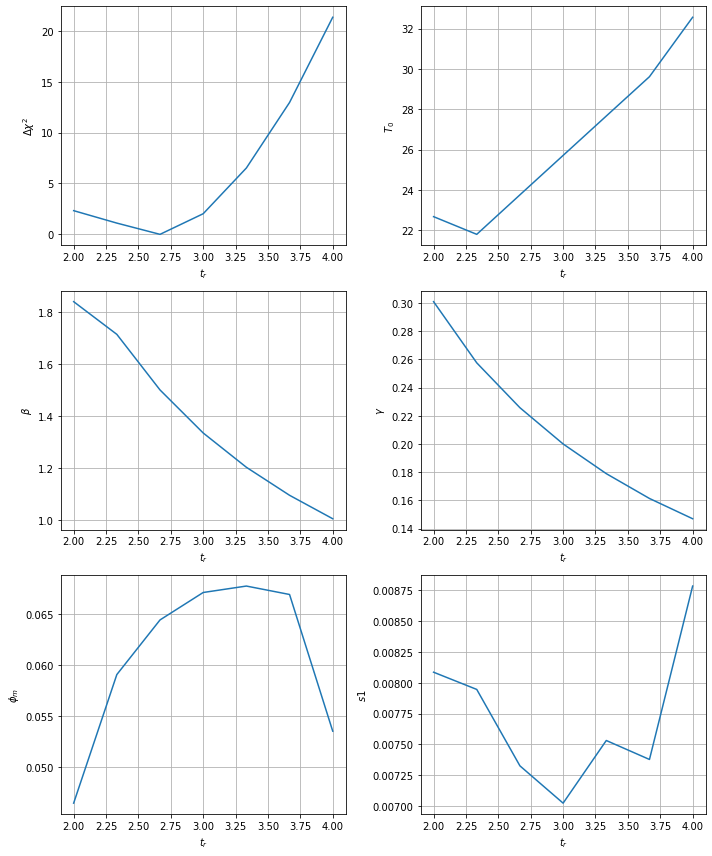

In [ ]:
dpars2 = dpars_revisit(dpars)
plt_tscan(dpars2, dpars2.tr.values, r'$t_r$')
dpars2

#### same for Ti 

recuperate best values of previous NB scan and refit with $T_0$ floating only

,t0,beta,gamma,tr,ti,n,phim,s1,fval
0,12.628088,1.515136,0.237398,2.7,4.00,2701743.0,0.059781,0.007338,147.762766
1,14.776946,1.469918,0.234076,2.7,4.25,2701743.0,0.061980,0.007119,142.989588
2,15.449783,1.473765,0.230233,2.7,4.50,2701743.0,0.064195,0.007181,141.628634
3,16.632378,1.477654,0.226435,2.7,4.75,2701743.0,0.066164,0.007199,141.134663
4,17.478338,1.481361,0.222742,2.7,5.00,2701743.0,0.067945,0.007089,141.486596
5,18.493637,1.485120,0.219068,2.7,5.25,2701743.0,0.069497,0.007171,142.660010
6,19.776558,1.488687,0.215478,2.7,5.50,2701743.0,0.070885,0.007229,144.640487
7,22.807314,1.397316,0.202917,2.7,5.75,2701743.0,0.068401,0.007066,149.230625


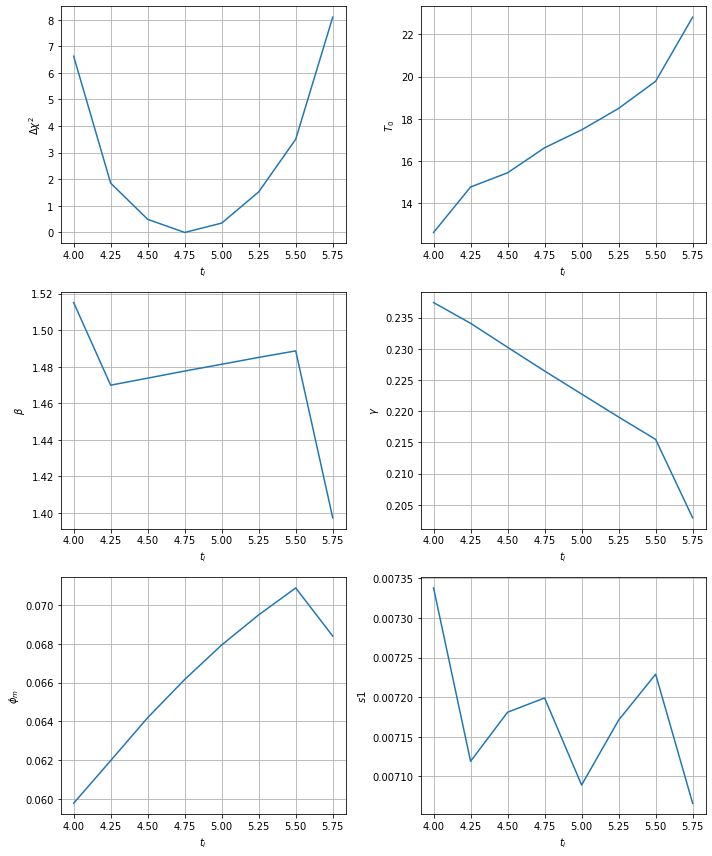

In [ ]:
path  = '/Users/hernando/investigacion/bio/C19/data/'
ifile = 'hgalicia_ti_scan_save.csv'
dpars = pd.read_csv(path + ifile)
plt_tscan(dpars, dpars.ti.values, r'$t_i$')
dpars

,beta,fval,gamma,n,phim,s1,t0,ti,tr
0,1.515136,142.032872,0.237398,2701743.0,0.059781,0.007338,19.170662,4.00,2.7
1,1.469918,138.322361,0.234076,2701743.0,0.061980,0.007119,20.846010,4.25,2.7
2,1.473765,137.058142,0.230233,2701743.0,0.064195,0.007181,21.819329,4.50,2.7
3,1.477654,136.576956,0.226435,2701743.0,0.066164,0.007199,22.789018,4.75,2.7
4,1.481361,136.863315,0.222742,2701743.0,0.067945,0.007089,23.756842,5.00,2.7
5,1.485120,137.843259,0.219068,2701743.0,0.069497,0.007171,24.720904,5.25,2.7
6,1.488687,139.511968,0.215478,2701743.0,0.070885,0.007229,25.682849,5.50,2.7
7,1.397316,147.380692,0.202917,2701743.0,0.068401,0.007066,29.111830,5.75,2.7


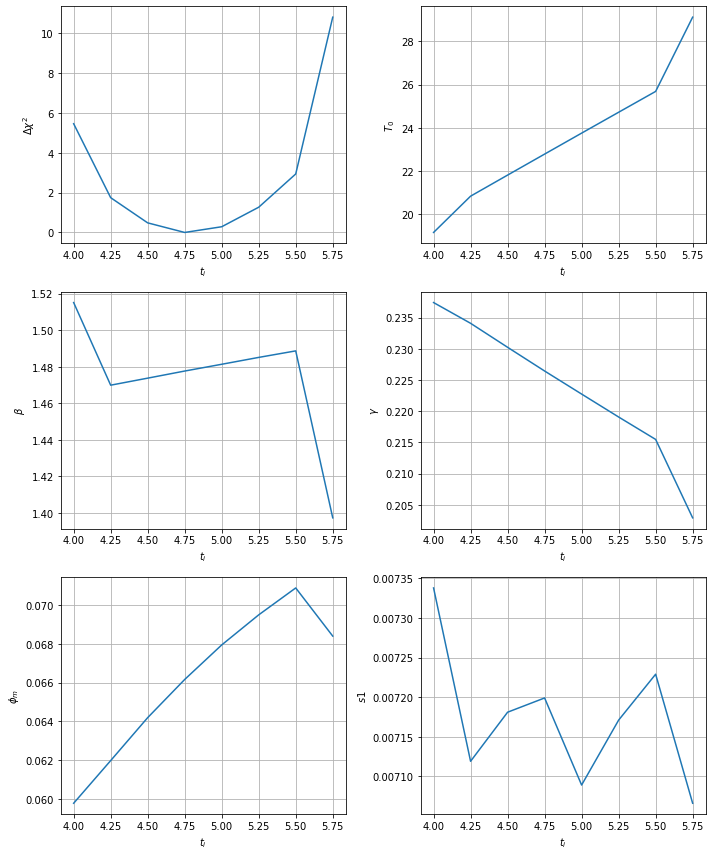

In [ ]:
dpars2 = dpars_revisit(dpars)
plt_tscan(dpars2, dpars2.ti.values, r'$t_i$')
dpars2

#### Recuperate the best fit and check

In [ ]:
kpars = kpars_from_df(dpars2, 3, fmodel)
ffit   = 'chi2'
plt_kpars(dates, cases, kpars0, fmodel = fmodel, ffit = ffit)
pmask  = ('t0', 'beta', 'gamma')
plt_kpars_fit(dates, cases, kpars0, pmask, fmodel = fmodel, ffit = ffit);

best pars  {'t0': 22.79, 'beta': 1.48, 'gamma': 0.226, 'ti': 4.75, 'tr': 2.7, 'n': 2701743.0, 'phim': 0.0661, 's1': 0.0072} , chi2  136.65732953786238
